In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from tqdm import tqdm

In [17]:
data_path = Path('data')
train_path = data_path / 'train'

print(f"Data path: {data_path}")
print(f"Train path: {train_path}")

Data path: data
Train path: data\train


In [33]:
def load_all_weeks_data(data_type='input'):
    weeks=range(1, 19)
    dfs = []
    
    for week in weeks:
        week_num = week
        
        filename = f"{data_type}_2023_w{week_num:02d}.csv"
        filepath = train_path / filename
        
        df = pd.read_csv(filepath)
        print(f"Loaded {filename}: {df.shape[0]:,} rows, {df.shape[1]} columns")
        
        if df is not None:
            df['week'] = week
            dfs.append(df)
    
    if dfs:
        combined_df = pd.concat(dfs, ignore_index=True)
        print(f"\nCombined {data_type} data: {combined_df.shape[0]:,} rows, {combined_df.shape[1]} columns")
        return combined_df
    return None

In [34]:
input_df = load_all_weeks_data('input')

Loaded input_2023_w01.csv: 285,714 rows, 23 columns
Loaded input_2023_w02.csv: 288,586 rows, 23 columns
Loaded input_2023_w03.csv: 297,757 rows, 23 columns
Loaded input_2023_w04.csv: 272,475 rows, 23 columns
Loaded input_2023_w05.csv: 254,779 rows, 23 columns
Loaded input_2023_w06.csv: 270,676 rows, 23 columns
Loaded input_2023_w07.csv: 233,597 rows, 23 columns
Loaded input_2023_w08.csv: 281,011 rows, 23 columns
Loaded input_2023_w09.csv: 252,796 rows, 23 columns
Loaded input_2023_w10.csv: 260,372 rows, 23 columns
Loaded input_2023_w11.csv: 243,413 rows, 23 columns
Loaded input_2023_w12.csv: 294,940 rows, 23 columns
Loaded input_2023_w13.csv: 233,755 rows, 23 columns
Loaded input_2023_w14.csv: 279,972 rows, 23 columns
Loaded input_2023_w15.csv: 281,820 rows, 23 columns
Loaded input_2023_w16.csv: 316,417 rows, 23 columns
Loaded input_2023_w17.csv: 277,582 rows, 23 columns
Loaded input_2023_w18.csv: 254,917 rows, 23 columns

Combined input data: 4,880,579 rows, 24 columns


In [20]:
output_df = load_all_weeks_data('output')

Loaded output_2023_w01.csv: 32,088 rows, 6 columns
Loaded output_2023_w02.csv: 32,180 rows, 6 columns
Loaded output_2023_w03.csv: 36,080 rows, 6 columns
Loaded output_2023_w04.csv: 30,147 rows, 6 columns
Loaded output_2023_w05.csv: 29,319 rows, 6 columns
Loaded output_2023_w06.csv: 31,162 rows, 6 columns
Loaded output_2023_w07.csv: 27,443 rows, 6 columns
Loaded output_2023_w08.csv: 33,017 rows, 6 columns
Loaded output_2023_w09.csv: 28,291 rows, 6 columns
Loaded output_2023_w10.csv: 29,008 rows, 6 columns
Loaded output_2023_w11.csv: 27,623 rows, 6 columns
Loaded output_2023_w12.csv: 32,156 rows, 6 columns
Loaded output_2023_w13.csv: 29,568 rows, 6 columns
Loaded output_2023_w14.csv: 32,873 rows, 6 columns
Loaded output_2023_w15.csv: 32,715 rows, 6 columns
Loaded output_2023_w16.csv: 36,508 rows, 6 columns
Loaded output_2023_w17.csv: 33,076 rows, 6 columns
Loaded output_2023_w18.csv: 29,682 rows, 6 columns

Combined output data: 562,936 rows, 7 columns


In [21]:
input_df.columns

Index(['game_id', 'play_id', 'player_to_predict', 'nfl_id', 'frame_id',
       'play_direction', 'absolute_yardline_number', 'player_name',
       'player_height', 'player_weight', 'player_birth_date',
       'player_position', 'player_side', 'player_role', 'x', 'y', 's', 'a',
       'dir', 'o', 'num_frames_output', 'ball_land_x', 'ball_land_y', 'week'],
      dtype='object')

In [22]:
input_df['player_position'].head()

0    FS
1    FS
2    FS
3    FS
4    FS
Name: player_position, dtype: object

In [23]:
output_df.columns

Index(['game_id', 'play_id', 'nfl_id', 'frame_id', 'x', 'y', 'week'], dtype='object')

In [24]:
def feature_engineering(df):
    fe_df = df.copy()

    def height_to_inches(height_str):
        """Convert height from 'ft-in' format to total inches"""
        if pd.isna(height_str) or height_str == '':
            return np.nan
        try:
            parts = height_str.replace("'", "-").replace('"', '').split('-')
            if len(parts) == 2:
                feet = int(parts[0])
                inches = int(parts[1])
                return feet * 12 + inches
            return np.nan
        except:
            return np.nan
    
    # Convert height to inches
    fe_df['player_height_inches'] = fe_df['player_height'].apply(height_to_inches)
    
    temporal_stats = input_df.groupby(['game_id', 'play_id', 'nfl_id']).agg({
        'x': ['mean', 'std', 'min', 'max', 'var'],
        'y': ['mean', 'std', 'min', 'max', 'var'],
        's': ['mean', 'std', 'max', 'min', 'var'],
        'a': ['mean', 'std', 'max', 'min', 'var'],
        'dir': lambda x: np.std(np.diff(x)) if len(x) > 1 else 0,
        'o': lambda x: np.std(np.diff(x)) if len(x) > 1 else 0,
    }).reset_index()
    
    temporal_stats.columns = ['_'.join(col).strip() if col[1] else col[0] 
                              for col in temporal_stats.columns.values]
    temporal_stats = temporal_stats.rename(columns={
        'dir_<lambda>': 'dir_change_rate',
        'o_<lambda>': 'orientation_change_rate'
    })

    fe_df = fe_df.merge(temporal_stats, on=['game_id', 'play_id', 'nfl_id'], how='left')

    # Get target receiver position
    targets = fe_df[fe_df['player_role'] == 'Targeted Receiver'][
        ['game_id', 'play_id', 'x', 'y']
    ].rename(columns={'x': 'target_x', 'y': 'target_y'})
    targets = targets.drop_duplicates(['game_id', 'play_id'])

    fe_df = fe_df.merge(targets, on=['game_id', 'play_id'], how='left')
    
    # Calculate vector components (dx, dy) from player to ball
    fe_df['dx_to_ball'] = fe_df['ball_land_x'] - fe_df['x']
    fe_df['dy_to_ball'] = fe_df['ball_land_y'] - fe_df['y']

    # Calculate Euclidean distance to ball landing position
    fe_df['distance_to_ball'] = np.sqrt(
        fe_df['dx_to_ball']**2 + fe_df['dy_to_ball']**2
    )
    
    # Calculate angle from player to ball (in radians and degrees)
    # atan2 gives angle in range [-π, π] radians
    fe_df['angle_to_ball_rad'] = np.arctan2(
        fe_df['dy_to_ball'], 
        fe_df['dx_to_ball']
    )
    fe_df['angle_to_ball_deg'] = np.degrees(fe_df['angle_to_ball_rad'])

    # Normalize angle to [0, 360] degrees for easier interpretation
    fe_df['angle_to_ball_360'] = (fe_df['angle_to_ball_deg'] + 360) % 360
    
    # Calculate unit vector components (normalized direction)
    # Handle case where distance is 0 to avoid division by zero
    fe_df['unit_dx_to_ball'] = np.where(
        fe_df['distance_to_ball'] > 0,
        fe_df['dx_to_ball'] / fe_df['distance_to_ball'],
        0
    )
    fe_df['unit_dy_to_ball'] = np.where(
        fe_df['distance_to_ball'] > 0,
        fe_df['dy_to_ball'] / fe_df['distance_to_ball'],
        0
    )

    # Manhattan distance (L1 norm) - sometimes useful for field-based movement
    fe_df['manhattan_distance_to_ball'] = (
        np.abs(fe_df['dx_to_ball']) + np.abs(fe_df['dy_to_ball'])
    )
    
    # Squared distance (useful for some models, avoids sqrt computation)
    fe_df['squared_distance_to_ball'] = (
        fe_df['dx_to_ball']**2 + fe_df['dy_to_ball']**2
    )

    # Convert player direction to radians
    player_dir_rad = np.radians(fe_df['dir'])
    
    # Calculate player velocity components
    fe_df['vx'] = fe_df['s'] * np.cos(player_dir_rad)
    fe_df['vy'] = fe_df['s'] * np.sin(player_dir_rad)
    
    # Project velocity onto direction to ball (dot product with unit vector)
    fe_df['velocity_toward_ball'] = (
        fe_df['vx'] * fe_df['unit_dx_to_ball'] + 
        fe_df['vy'] * fe_df['unit_dy_to_ball']
    )
    
    # Calculate perpendicular velocity component
    fe_df['velocity_perpendicular_ball'] = (
        fe_df['vx'] * (-fe_df['unit_dy_to_ball']) + 
        fe_df['vy'] * fe_df['unit_dx_to_ball']
    )

    # Difference between player orientation and angle to ball
    fe_df['orientation_diff_to_ball'] = (
        fe_df['angle_to_ball_360'] - fe_df['o']
    )
    
    # Normalize to [-180, 180] range
    fe_df['orientation_diff_to_ball'] = np.where(
        fe_df['orientation_diff_to_ball'] > 180,
        fe_df['orientation_diff_to_ball'] - 360,
        fe_df['orientation_diff_to_ball']
    )
    fe_df['orientation_diff_to_ball'] = np.where(
        fe_df['orientation_diff_to_ball'] < -180,
        fe_df['orientation_diff_to_ball'] + 360,
        fe_df['orientation_diff_to_ball']
    )
    
    # Absolute orientation difference
    fe_df['abs_orientation_diff_to_ball'] = np.abs(
        fe_df['orientation_diff_to_ball']
    )
    
    # Is player facing toward ball? (within 90 degrees)
    fe_df['facing_ball'] = (fe_df['abs_orientation_diff_to_ball'] < 90).astype(int)

    # Distance from player to sidelines
    fe_df['distance_to_left_sideline'] = fe_df['y']
    fe_df['distance_to_right_sideline'] = 53.3 - fe_df['y']
    fe_df['distance_to_nearest_sideline'] = np.minimum(
        fe_df['distance_to_left_sideline'],
        fe_df['distance_to_right_sideline']
    )
    
    # Distance from ball to sidelines
    fe_df['ball_distance_to_left_sideline'] = fe_df['ball_land_y']
    fe_df['ball_distance_to_right_sideline'] = 53.3 - fe_df['ball_land_y']
    fe_df['ball_distance_to_nearest_sideline'] = np.minimum(
        fe_df['ball_distance_to_left_sideline'],
        fe_df['ball_distance_to_right_sideline']
    )

    # Binned distance categories
    fe_df['distance_to_ball_bin'] = pd.cut(
        fe_df['distance_to_ball'],
        bins=[1, 5, 10, 25, 50, 60, 70, 80, 90, 100, np.inf],
        labels=['extremely_close', 
                'very_close', 
                'close', 
                'close_medium', 
                'medium', 
                'medium_far', 
                'far', 
                'very_far', 
                'extremely_far', 
                'maximum_distance']
    )
    
    # Quadrant of ball relative to player
    fe_df['ball_quadrant'] = 'unknown'
    fe_df.loc[(fe_df['dx_to_ball'] >= 0) & (fe_df['dy_to_ball'] >= 0), 'ball_quadrant'] = 'front_right'
    fe_df.loc[(fe_df['dx_to_ball'] >= 0) & (fe_df['dy_to_ball'] < 0), 'ball_quadrant'] = 'front_left'
    fe_df.loc[(fe_df['dx_to_ball'] < 0) & (fe_df['dy_to_ball'] >= 0), 'ball_quadrant'] = 'back_right'
    fe_df.loc[(fe_df['dx_to_ball'] < 0) & (fe_df['dy_to_ball'] < 0), 'ball_quadrant'] = 'back_left'

    # Find the nearest yard line (rounded to nearest integer)
    fe_df['nearest_yard_line'] = np.round(fe_df['ball_land_x']).astype(int)
    
    # Distance to nearest yard line (can be positive or negative)
    fe_df['distance_to_nearest_yard'] = fe_df['ball_land_x'] - fe_df['nearest_yard_line']
    
    # Absolute distance to nearest yard line
    fe_df['abs_distance_to_nearest_yard'] = np.abs(fe_df['distance_to_nearest_yard'])
    
    # Which side of the yard line (behind or past)
    fe_df['ball_past_yard_line'] = (fe_df['distance_to_nearest_yard'] > 0).astype(int)

    # Find nearest 5-yard line
    fe_df['nearest_5_yard_line'] = (np.round(fe_df['ball_land_x'] / 5) * 5).astype(int)
    
    # Distance to nearest 5-yard line
    fe_df['distance_to_nearest_5_yard'] = fe_df['ball_land_x'] - fe_df['nearest_5_yard_line']
    fe_df['abs_distance_to_nearest_5_yard'] = np.abs(fe_df['distance_to_nearest_5_yard'])
    
    # Previous and next 5-yard lines
    fe_df['prev_5_yard_line'] = (np.floor(fe_df['ball_land_x'] / 5) * 5).astype(int)
    fe_df['next_5_yard_line'] = (np.ceil(fe_df['ball_land_x'] / 5) * 5).astype(int)
    
    # Position between 5-yard lines (0 to 5)
    fe_df['position_within_5_yard_segment'] = fe_df['ball_land_x'] - fe_df['prev_5_yard_line']
    
    # Percentage through 5-yard segment
    fe_df['pct_through_5_yard_segment'] = fe_df['position_within_5_yard_segment'] / 5

    # Find nearest 10-yard line (major field markers)
    fe_df['nearest_10_yard_line'] = (np.round(fe_df['ball_land_x'] / 10) * 10).astype(int)
    
    # Distance to nearest 10-yard line
    fe_df['distance_to_nearest_10_yard'] = fe_df['ball_land_x'] - fe_df['nearest_10_yard_line']
    fe_df['abs_distance_to_nearest_10_yard'] = np.abs(fe_df['distance_to_nearest_10_yard'])
    
    # Previous and next 10-yard lines
    fe_df['prev_10_yard_line'] = (np.floor(fe_df['ball_land_x'] / 10) * 10).astype(int)
    fe_df['next_10_yard_line'] = (np.ceil(fe_df['ball_land_x'] / 10) * 10).astype(int)
    
    # Position within 10-yard segment
    fe_df['position_within_10_yard_segment'] = fe_df['ball_land_x'] - fe_df['prev_10_yard_line']
    
    # Percentage through 10-yard segment
    fe_df['pct_through_10_yard_segment'] = fe_df['position_within_10_yard_segment'] / 10

    # Determine field zone (red zone, midfield, etc.)
    conditions = [
        (fe_df['ball_land_x'] <= 20),
        (fe_df['ball_land_x'] > 20) & (fe_df['ball_land_x'] <= 40),
        (fe_df['ball_land_x'] > 40) & (fe_df['ball_land_x'] <= 60),
        (fe_df['ball_land_x'] > 60) & (fe_df['ball_land_x'] <= 80),
        (fe_df['ball_land_x'] > 80) & (fe_df['ball_land_x'] <= 100),
        (fe_df['ball_land_x'] > 100)
    ]
    
    choices = [
        'own_red_zone',      # 0-20 yards
        'own_territory',      # 20-40 yards  
        'midfield_zone',      # 40-60 yards
        'opponent_territory', # 60-80 yards
        'opponent_red_zone',  # 80-100 yards
        'opponent_end_zone'   # 100+ yards
    ]
    
    fe_df['field_zone'] = np.select(conditions, choices, default='unknown')
    
    # Distance to key field positions
    fe_df['distance_to_midfield'] = np.abs(fe_df['ball_land_x'] - 60)
    fe_df['distance_to_own_goal'] = fe_df['ball_land_x']
    fe_df['distance_to_opponent_goal'] = 120 - fe_df['ball_land_x']

    # Is ball near a major yard line? (within 1 yard of 10-yard markers)
    fe_df['near_major_yard_line'] = (fe_df['abs_distance_to_nearest_10_yard'] <= 1).astype(int)
    
    # Is ball very close to any yard line? (within 0.5 yards)
    fe_df['very_close_to_yard_line'] = (fe_df['abs_distance_to_nearest_yard'] <= 0.5).astype(int)
    
    # Exact yard line indicators
    fe_df['on_5_yard_line'] = (fe_df['abs_distance_to_nearest_5_yard'] < 0.1).astype(int)
    fe_df['on_10_yard_line'] = (fe_df['abs_distance_to_nearest_10_yard'] < 0.1).astype(int)

    # Adjust features based on play direction
    # If play direction is 'left', we need to flip the x-axis perspective
    fe_df['adjusted_ball_x'] = np.where(
        fe_df['play_direction'] == 'left',
        120 - fe_df['ball_land_x'],
        fe_df['ball_land_x']
    )
    
    # Yards to gain (distance to opponent's end zone)
    fe_df['yards_to_endzone'] = np.where(
        fe_df['play_direction'] == 'left',
        fe_df['ball_land_x'],
        120 - fe_df['ball_land_x']
    )

    # Bin the field into segments
    fe_df['field_segment_20'] = pd.cut(
        fe_df['ball_land_x'],
        bins=[0, 20, 40, 60, 80, 100, 120],
        labels=['0-20', '20-40', '40-60', '60-80', '80-100', '100-120'],
        include_lowest=True
    )
    
    # Quarter of field
    fe_df['field_quarter'] = pd.cut(
        fe_df['ball_land_x'],
        bins=[0, 30, 60, 90, 120],
        labels=['Q1', 'Q2', 'Q3', 'Q4'],
        include_lowest=True
    )
    
    # Third of field  
    fe_df['field_third'] = pd.cut(
        fe_df['ball_land_x'],
        bins=[0, 40, 80, 120],
        labels=['defensive_third', 'middle_third', 'offensive_third'],
        include_lowest=True
    )

    # Calculate release height (approximation: 95% of player height for QB release point) of ball
    # Adjust multiplier based on player role if needed
    fe_df['release_height_inches'] = np.where(
        fe_df['player_role'] == 'Passer',
        fe_df['player_height_inches'] * 0.95,  # QB releases near head height
        fe_df['player_height_inches'] * 0.85   # Other players might release lower
    )

    # Convert to yards for consistency with field coordinates
    fe_df['release_height_yards'] = fe_df['release_height_inches'] / 36.0

    # Calculate horizontal distance from release to landing
    # Assuming ball is released from passer's position
    passer_info = fe_df[fe_df['player_role'] == 'Passer'][
        ['game_id', 'play_id', 'x', 'y']
    ].rename(columns={'x': 'passer_x', 'y': 'passer_y'})
    passer_info = passer_info.drop_duplicates(['game_id', 'play_id'])
    
    fe_df = fe_df.merge(passer_info, on=['game_id', 'play_id'], how='left')

    # Horizontal distance from passer to ball landing point
    fe_df['pass_horizontal_distance'] = np.sqrt(
        (fe_df['ball_land_x'] - fe_df['passer_x'])**2 + 
        (fe_df['ball_land_y'] - fe_df['passer_y'])**2
    )

    # Estimate maximum arc height (apex)
    # Rule of thumb: apex height = release_height + (horizontal_distance / 4)
    fe_df['arc_apex_height_yards'] = (
        fe_df['release_height_yards'] + 
        (fe_df['pass_horizontal_distance'] / 4)  
    )

    # Calculate arc length (approximate distance ball travels through air)
    # Using parabolic arc length approximation
    # Arc length ≈ horizontal_distance * (1 + (2/3) * (height/horizontal)^2)
    height_ratio = fe_df['arc_apex_height_yards'] / (fe_df['pass_horizontal_distance'] + 1e-6)
    fe_df['arc_length_yards'] = fe_df['pass_horizontal_distance'] * (
        1 + (2/3) * height_ratio**2
    )

    # Calculate radius of curvature at apex (for parabolic trajectory)
    # R = (horizontal_distance/2)^2 / (2 * apex_height)
    fe_df['arc_radius_curvature'] = np.where(
        fe_df['arc_apex_height_yards'] > 0,
        (fe_df['pass_horizontal_distance'] / 2)**2 / (2 * fe_df['arc_apex_height_yards']),
        np.nan
    )

    # Estimate time of flight (simplified physics model)
    # Using kinematic equations with gravity = 32.2 ft/s² = 10.73 yards/s²
    g = 10.73  # gravity in yards/s²
    
    # Time to apex and total flight time (simplified)
    fe_df['estimated_flight_time'] = np.sqrt(
        2 * fe_df['arc_apex_height_yards'] / g
    ) * 2
    
    # Calculate release and landing angles
    # Release angle (angle of initial velocity vector)
    fe_df['release_angle_deg'] = np.degrees(np.arctan(
        2 * fe_df['arc_apex_height_yards'] / (fe_df['pass_horizontal_distance'] + 1e-6)
    ))
    
    # Arc "steepness" metrics
    fe_df['arc_steepness_ratio'] = (
        fe_df['arc_apex_height_yards'] / (fe_df['pass_horizontal_distance'] + 1e-6)
    )

    # Categorize arc types
    conditions = [
        (fe_df['arc_steepness_ratio'] < 0.1),
        (fe_df['arc_steepness_ratio'] >= 0.1) & (fe_df['arc_steepness_ratio'] < 0.2),
        (fe_df['arc_steepness_ratio'] >= 0.2) & (fe_df['arc_steepness_ratio'] < 0.3),
        (fe_df['arc_steepness_ratio'] >= 0.3)
    ]
    choices = ['line_drive', 'low_arc', 'medium_arc', 'high_arc']
    fe_df['arc_type'] = np.select(conditions, choices, default='unknown')

    # Player-specific arc interaction features
    # Distance from player to arc apex point (horizontal projection)
    arc_apex_x = fe_df['passer_x'] + (fe_df['ball_land_x'] - fe_df['passer_x']) * 0.5
    arc_apex_y = fe_df['passer_y'] + (fe_df['ball_land_y'] - fe_df['passer_y']) * 0.5
    
    fe_df['distance_to_arc_apex'] = np.sqrt(
        (fe_df['x'] - arc_apex_x)**2 + 
        (fe_df['y'] - arc_apex_y)**2
    )

    # Is player under the arc path?
    # Check if player is between passer and landing point
    dot_product = (
        (fe_df['x'] - fe_df['passer_x']) * (fe_df['ball_land_x'] - fe_df['passer_x']) +
        (fe_df['y'] - fe_df['passer_y']) * (fe_df['ball_land_y'] - fe_df['passer_y'])
    )
    
    squared_pass_distance = fe_df['pass_horizontal_distance']**2
    
    # Projection parameter (0 to 1 means between passer and landing)
    fe_df['arc_projection_param'] = dot_product / (squared_pass_distance + 1e-6)

    # Player is "under arc" if projection is between 0 and 1
    fe_df['under_arc_path'] = (
        (fe_df['arc_projection_param'] >= 0) & 
        (fe_df['arc_projection_param'] <= 1)
    ).astype(int)
    
    # Distance from player to arc path (perpendicular distance)
    # Only meaningful if player is under the arc
    closest_point_x = (
        fe_df['passer_x'] + 
        fe_df['arc_projection_param'] * (fe_df['ball_land_x'] - fe_df['passer_x'])
    )
    closest_point_y = (
        fe_df['passer_y'] + 
        fe_df['arc_projection_param'] * (fe_df['ball_land_y'] - fe_df['passer_y'])
    )
    
    fe_df['perpendicular_distance_to_arc'] = np.sqrt(
        (fe_df['x'] - closest_point_x)**2 + 
        (fe_df['y'] - closest_point_y)**2
    )
    
    # Set to NaN if not under arc
    fe_df.loc[fe_df['under_arc_path'] == 0, 'perpendicular_distance_to_arc'] = np.nan

    # Ball height at player position (if under arc)
    # Using parabolic equation
    fe_df['ball_height_at_player'] = np.where(
        fe_df['under_arc_path'] == 1,
        fe_df['release_height_yards'] + 
        4 * fe_df['arc_apex_height_yards'] * fe_df['arc_projection_param'] * 
        (1 - fe_df['arc_projection_param']),
        np.nan
    )
    
    # Can player potentially intercept? (considering typical reach)
    typical_reach_height = 8 / 36.0  # 8 feet in yards
    fe_df['can_reach_ball'] = (
        (fe_df['under_arc_path'] == 1) & 
        (fe_df['ball_height_at_player'] <= fe_df['player_height_inches'] / 36.0 + typical_reach_height)
    ).astype(int)

    # Pass classification based on distance and arc
    conditions = [
        (fe_df['pass_horizontal_distance'] < 5),
        (fe_df['pass_horizontal_distance'] >= 5) & (fe_df['pass_horizontal_distance'] < 15),
        (fe_df['pass_horizontal_distance'] >= 15) & (fe_df['pass_horizontal_distance'] < 25),
        (fe_df['pass_horizontal_distance'] >= 25)
    ]
    choices = ['screen_pass', 'short_pass', 'medium_pass', 'deep_pass']
    fe_df['pass_depth_category'] = np.select(conditions, choices, default='unknown')
    
    # Combined pass type (depth + arc)
    fe_df['pass_type_combined'] = (
        fe_df['pass_depth_category'] + '_' + fe_df['arc_type']
    )
    
    return fe_df, temporal_stats, targets

In [25]:
fe_df, temporal_stats, targets = feature_engineering(input_df)

In [26]:
targets

,game_id,play_id,target_x,target_y
208,2023090700,101,41.03,12.17
618,2023090700,194,93.33,27.85
854,2023090700,219,80.57,10.65
1381,2023090700,361,20.65,37.90
1632,2023090700,436,29.46,35.92
...,...,...,...,...
4879360,2024010713,3836,62.39,17.26
4879611,2024010713,3906,76.65,22.19
4879846,2024010713,3936,66.81,30.39
4880200,2024010713,3995,50.28,41.22


In [27]:
fe_df.head()

,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,...,arc_steepness_ratio,arc_type,distance_to_arc_apex,arc_projection_param,under_arc_path,perpendicular_distance_to_arc,ball_height_at_player,can_reach_ball,pass_depth_category,pass_type_combined
0,2023090700,101,False,54527,1,right,42,Bryan Cook,6-1,210,...,0.293249,medium_arc,22.107479,0.113097,1,15.842417,6.412690,0,deep_pass,deep_pass_medium_arc
1,2023090700,101,False,54527,2,right,42,Bryan Cook,6-1,210,...,0.293249,medium_arc,22.107479,0.113097,1,15.842417,6.412690,0,deep_pass,deep_pass_medium_arc
2,2023090700,101,False,54527,3,right,42,Bryan Cook,6-1,210,...,0.293249,medium_arc,22.097521,0.113287,1,15.835918,6.419587,0,deep_pass,deep_pass_medium_arc
3,2023090700,101,False,54527,4,right,42,Bryan Cook,6-1,210,...,0.293249,medium_arc,22.089401,0.113804,1,15.844620,6.438262,0,deep_pass,deep_pass_medium_arc
4,2023090700,101,False,54527,5,right,42,Bryan Cook,6-1,210,...,0.293249,medium_arc,22.071344,0.114512,1,15.846823,6.463786,0,deep_pass,deep_pass_medium_arc


In [28]:
fe_df.columns

Index(['game_id', 'play_id', 'player_to_predict', 'nfl_id', 'frame_id',
       'play_direction', 'absolute_yardline_number', 'player_name',
       'player_height', 'player_weight',
       ...
       'arc_steepness_ratio', 'arc_type', 'distance_to_arc_apex',
       'arc_projection_param', 'under_arc_path',
       'perpendicular_distance_to_arc', 'ball_height_at_player',
       'can_reach_ball', 'pass_depth_category', 'pass_type_combined'],
      dtype='object', length=125)

In [29]:
# Visualization function for the new features
def visualize_ball_vectors(fe_df, sample_play=None):
    if sample_play is None:
        # Get a random play
        sample_play = fe_df[['game_id', 'play_id']].drop_duplicates().sample(1).iloc[0]

    game_id = sample_play['game_id']
    play_id = sample_play['play_id']
    
    play_data = fe_df[
        (fe_df['game_id'] == sample_play['game_id']) & 
        (fe_df['play_id'] == sample_play['play_id']) &
        (fe_df['frame_id'] == fe_df['frame_id'].min())  # First frame only
    ]
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    # Plot field
    ax.set_xlim(0, 120)
    ax.set_ylim(0, 53.3)
    ax.set_aspect('equal')
    ax.set_xlabel('Field Length (yards)')
    ax.set_ylabel('Field Width (yards)')
    ax.set_title(f'Player Positions and Ball Landing\nGame: {sample_play["game_id"]}, Play: {sample_play["play_id"]}')
    
    # Add field lines
    for y in [0, 53.3]:
        ax.axhline(y, color='white', linewidth=2)
    for x in range(0, 121, 10):
        ax.axvline(x, color='white', linewidth=0.5, alpha=0.5)
    
    # Color by team
    colors = {'Offense': 'blue', 'Defense': 'red'}
    
    for side in ['Offense', 'Defense']:
        side_data = play_data[play_data['player_side'] == side]
        if len(side_data) > 0:
            ax.scatter(
                side_data['x'], 
                side_data['y'], 
                c=colors[side], 
                s=100, 
                alpha=0.7, 
                label=side,
                edgecolors='white',
                linewidth=1
            )
            
            # Draw vectors to ball for a subset of players
            for _, player in side_data.iterrows():
                if player['distance_to_ball'] < 30:  # Only show vectors for nearby players
                    ax.arrow(
                        player['x'], 
                        player['y'],
                        player['dx_to_ball'] * 0.8,  # Scale down arrow length
                        player['dy_to_ball'] * 0.8,
                        head_width=0.5,
                        head_length=0.5,
                        fc=colors[side],
                        ec=colors[side],
                        alpha=0.3,
                        length_includes_head=True
                    )
    
    # Plot ball landing position
    if len(play_data) > 0:
        ball_x = play_data['ball_land_x'].iloc[0]
        ball_y = play_data['ball_land_y'].iloc[0]
        ax.scatter(
            ball_x, 
            ball_y, 
            c='yellow', 
            s=200, 
            marker='*', 
            edgecolors='black',
            linewidth=2,
            label='Ball Landing',
            zorder=10
        )
    
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    ax.set_facecolor('#2e7d32')  # Green field
    
    plt.tight_layout()
    plt.savefig(f'game_{game_id}_play_{play_id}_ball_vector.png')
    plt.show()
    
    return fig

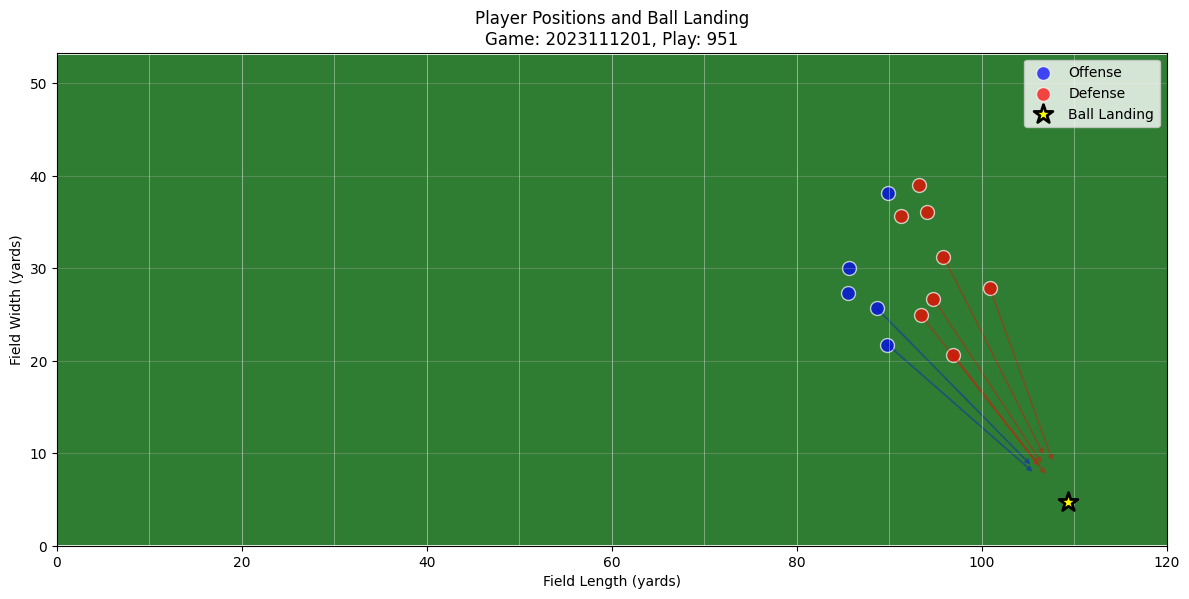

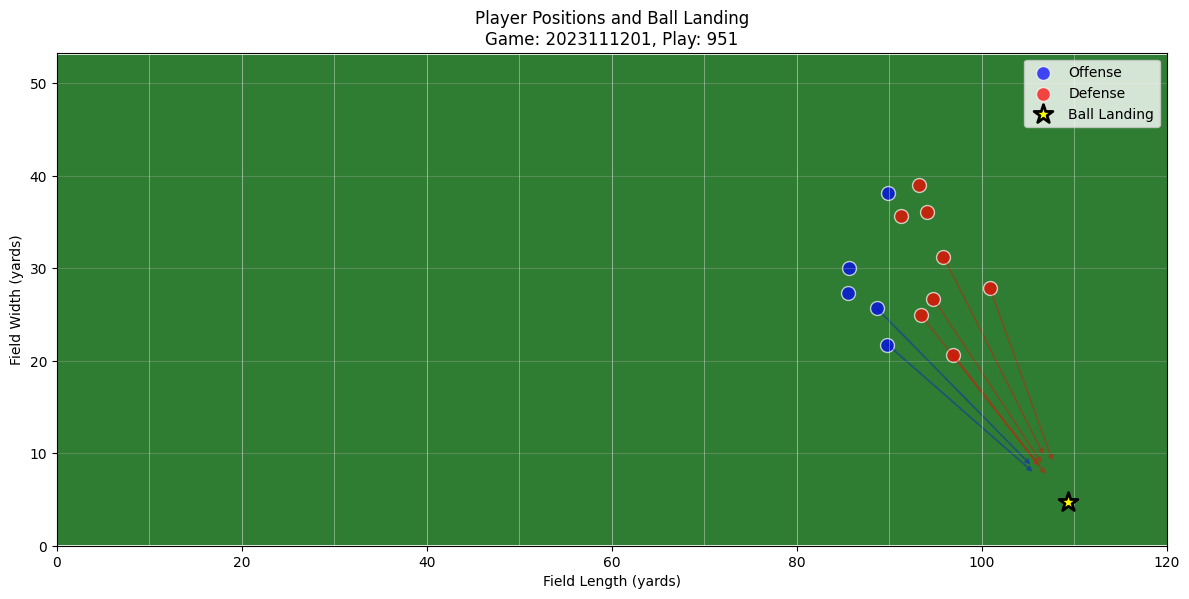

In [30]:
visualize_ball_vectors(fe_df)